<a href="https://colab.research.google.com/github/AokiMasataka/colab/blob/main/CIFAR10_Data2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data2vec
参考: https://ai.facebook.com/blog/the-first-high-performance-self-supervised-algorithm-that-works-for-speech-vision-and-text

In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional
from torch.backends import cudnn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False

In [2]:
class MyDataset(Dataset):
    def __init__(self, data, cut_out_size=None):
        self.data_list = data
        self.cut_out_size = cut_out_size

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        one_data = self.data_list[index]
        image = one_data[0]
        image = np.array(image, dtype=np.float32) / 255.0
        image = image.transpose(2, 0, 1)
        image = torch.tensor(image, dtype=torch.float32)
        if self.cut_out_size is not None:
            cut_out_image = self.cut_out(deepcopy(image))
            return image, cut_out_image
        return image, one_data[1]
    
    def cut_out(self, image):
        x_pos = np.random.randint(0, 32 - self.cut_out_size)
        y_pos = np.random.randint(0, 32 - self.cut_out_size)
        image[:, x_pos: x_pos + self.cut_out_size, y_pos: y_pos + self.cut_out_size] = 0
        return image

In [3]:
train_data = CIFAR10(root='.', train=True, transform=None, download=True)
valid_data = CIFAR10(root='.', train=False, transform=None, download=True)

cut_out_data = [train_data[i] for i in range(0, 20000)]
train_data = [train_data[i] for i in range(20000, 40000)]

cut_out_dataset = MyDataset(cut_out_data, cut_out_size=16)
train_dataset = MyDataset(train_data)
valid_dataset = MyDataset(valid_data)

cut_out_loader = DataLoader(cut_out_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


torch.Size([3, 32, 32]) tensor(0.) tensor(1.)


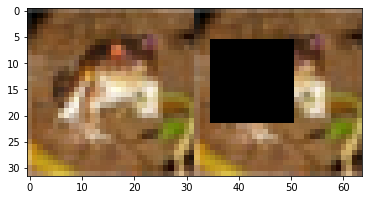

In [4]:
origin_images, cut_out_images = iter(cut_out_loader).__next__()
origin_image = origin_images[0]
cut_out_image = cut_out_images[0]
print(origin_image.shape, origin_image.min(), origin_image.max())
 
origin_image = np.array(origin_image).transpose((1,2,0))
cut_out_image = np.array(cut_out_image).transpose((1,2,0))
image = np.concatenate((origin_image, cut_out_image), axis=1)
plt.imshow(image)

In [5]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.net = resnet18(pretrained=False, num_classes=10)
    
    def forward(self, image):
        return self.net(image)
    
    def extract_features(self, image):
        features = []
        x = self.net.conv1(image)
        x = self.net.bn1(x)
        x = self.net.relu(x)

        x_1 = self.net.layer1(x)
        x_2 = self.net.layer2(x_1)
        features.append(x_2)
        x_3 = self.net.layer3(x_2)
        features.append(x_3)
        x_4 = self.net.layer4(x_3)
        features.append(x_4)
        return features

In [6]:
@torch.no_grad()
def valid(model, valid_loader):
    model.eval()
    n_labels = valid_loader.dataset.__len__()
    acc, mean_loss  = 0, 0
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        loss = functional.cross_entropy(pred, labels)
        acc += sum(pred.cpu().argmax(dim=1) == labels.cpu())
        mean_loss += loss.item()
    acc = acc / n_labels
    mean_loss = mean_loss / n_labels
    return acc, mean_loss

In [7]:
def train(model):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    max_acc = float('-Inf')
    for epoch in range(1, 8 + 1):
        model.train()
        loss_list = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            pred = model(images)
            loss = functional.cross_entropy(pred, labels)
            loss_list.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        mean_loss = np.mean(loss_list)
        acc, valid_loss = valid(model, valid_loader)
        if max_acc < acc:
            max_acc = acc
        print(f'INFO: [Train]  epoch: {epoch}  train loss: {mean_loss:.6f}  valid loss: {valid_loss:.6f}  acc: {acc:.3f}')
    return max_acc

In [8]:
def train_data2vec(student_model, teacher_model):
    teacher_model.eval()
    optimizer = optim.Adam(student_model.parameters(), lr=0.001)
    for epoch in range(1, 8 + 1):
        teacher_model.train()
        loss_list = []
        for origin_images, cut_out_image in cut_out_loader:
            origin_images, cut_out_image = origin_images.to(device), cut_out_image.to(device)

            with torch.no_grad():
                teacher_pred = teacher_model.extract_features(origin_images)
            student_pred = student_model.extract_features(cut_out_image)

            for i in range(3):
                if i == 0:
                    loss = functional.mse_loss(student_pred[i], teacher_pred[i])
                else:
                    loss = loss + functional.mse_loss(student_pred[i], teacher_pred[i])
            
            loss_list.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        mean_loss = np.mean(loss_list)
        print(f'INFO: [Data2vec]  epoch: {epoch}  train loss: {mean_loss:.5f}')

In [9]:
student_model = CustomNet().to(device)
teacher_model = CustomNet().to(device)

teacher_acc = train(teacher_model)
train_data2vec(student_model, teacher_model)
student_acc = train(student_model)
print(f'teacher model accuracy: {teacher_acc:.6f}')
print(f'student model accuracy: {student_acc:.6f}')

INFO: [Train]  epoch: 1  train loss: 1.583418  valid loss: 0.025970  acc: 0.403
INFO: [Train]  epoch: 2  train loss: 1.247156  valid loss: 0.029293  acc: 0.385
INFO: [Train]  epoch: 3  train loss: 1.057758  valid loss: 0.026330  acc: 0.454
INFO: [Train]  epoch: 4  train loss: 0.902117  valid loss: 0.027691  acc: 0.472
INFO: [Train]  epoch: 5  train loss: 0.760756  valid loss: 0.021111  acc: 0.597
INFO: [Train]  epoch: 6  train loss: 0.659506  valid loss: 0.026020  acc: 0.535
INFO: [Train]  epoch: 7  train loss: 0.557459  valid loss: 0.021646  acc: 0.610
INFO: [Train]  epoch: 8  train loss: 0.460098  valid loss: 0.030437  acc: 0.541
INFO: [Data2vec]  epoch: 1  train loss: 2.06769
INFO: [Data2vec]  epoch: 2  train loss: 1.59567
INFO: [Data2vec]  epoch: 3  train loss: 1.42119
INFO: [Data2vec]  epoch: 4  train loss: 1.32030
INFO: [Data2vec]  epoch: 5  train loss: 1.26026
INFO: [Data2vec]  epoch: 6  train loss: 1.21450
INFO: [Data2vec]  epoch: 7  train loss: 1.17425
INFO: [Data2vec]  epoch: